# <center> Module 5

Group: 12<br>
Darko Petrov<br>
Alexander Lendon

#### 1

#### 2

C:\Users\lendo\AppData\Local\Temp\ipykernel_21768\2618127062.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\lendo\AppData\Local\Temp\ipykernel_21768\2618127062.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


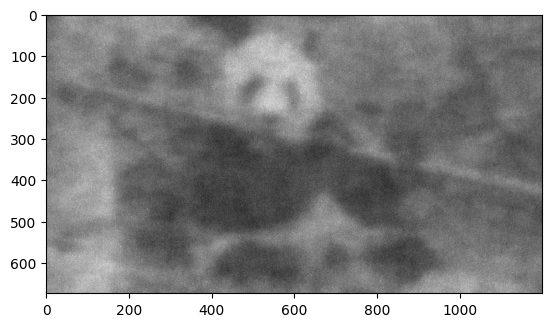

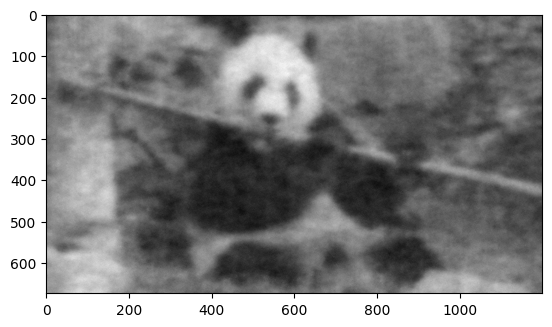

In [8]:
import imageio.v2 as iio
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as transform

img = iio.imread("panda.png")
# generating grayscale image:
bw_img=np.sum(img,2)/3
N = bw_img.shape[0]*img.shape[1]
# Take a number sample_num of samples and generate their
# horizontal and vertical coordinates (indicies) randomly in arrays xcoord, ycoord
sample_num = int(N * 0.05)  # 5% of N
xcoord = np.random.randint(0, bw_img.shape[0], sample_num)
ycoord = np.random.randint(0, bw_img.shape[1], sample_num)

# Store these samples in an array called y.
y = bw_img[xcoord, ycoord]

# The goal is to find the dct components x of the image from y and
# then use inverse dct to reconstruct the image.

def sq_loss_gradient(x,y, xcoord, ycoord):
    # samp_approx is Ax
    img_approx= transform.idct(transform.idct(x, axis=1, norm='ortho'),axis=0, norm='ortho')
    #print(y.shape, xcoord.shape, ycoord.shape)
    samp_approx=np.zeros(y.shape)
    for l in range(y.shape[0]):
        samp_approx[l]=img_approx[xcoord[l],ycoord[l]]

    # The following calculates e=Ax-y
    error=samp_approx-y
    img_err=np.zeros(bw_img.shape)
    for l in range(sample_num):
        img_err[xcoord[l],ycoord[l]]=error[l]
    # This calculates A^Te which is the gradient 
    grad=transform.dct(transform.dct(img_err, axis=0, norm='ortho'),axis=1, norm='ortho')

    return grad, samp_approx

def shrinkage(x,alpha):
    # Implement the shrinkage operator which is the proximal operator
    # of the regularizer
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)
    
def calculate_obj_ISTA(x, y, Ax, lamb):
    return np.sum((y - Ax) + lamb*np.linalg.norm(x))

def ISTA(y, xcoord, ycoord, alpha, xinit, step=0.99, iternum=100):
    # Implement the iteration and also calculate the objective value and
        # the vaue of the regularization term at each iteration
        # Calculate the gradient
    # Initialization:
    x = []  # Initialize x
    x.append(xinit)  # x[0] is the initial point
    obj_val = []
    
    for iter in range(iternum):
        grad, Ax = sq_loss_gradient(x[-1], y, xcoord, ycoord)
        x_hat = x - step*grad
        x  = shrinkage(x_hat, alpha)
        obj_val.append(calculate_obj_ISTA(x, y, Ax, step))
    return x[-1]

def FISTA(y, xcoord, ycoord, alpha, xinit, step=0.99, iternum=100):
    # Initialization:
    x = xinit  # Initialize x
    x_prev = xinit  # Initialize x_prev
    z = xinit.copy()  # Initialize z
    t = 1  # Initialize t
    t_prev = 1  # Initialize t_prev

    for iter in range(iternum - 1):
        # Compute the gradient at z
        grad, _ = sq_loss_gradient(z, y, xcoord, ycoord)

        # Update x
        x = shrinkage(z - step * grad, alpha)

        # Update t
        t = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2

        # Update z
        z = x + ((t_prev - 1) / t) * (x - x_prev)

        # Update x_prev and t_prev for the next iteration
        x_prev = x
        t_prev = t

    return x

# run ISTA/FISTA and generate the approximate DCT coefficients x
# Then, generate the recovered image
    #aplha is related to the step size and a regularisation parameter
    
alpha = 10
x_ISTA = ISTA(y, xcoord, ycoord, alpha, np.zeros(bw_img.shape), step=0.99, iternum=100)
img_approx_ISTA = transform.idct(transform.idct(x_ISTA, axis=1),axis=0, norm='ortho')

x_FISTA = FISTA(y, xcoord, ycoord, alpha, np.zeros(bw_img.shape), step=0.99, iternum=100)
img_approx_FISTA = transform.idct(transform.idct(x_FISTA, axis=1),axis=0, norm='ortho')

# Plot the result
fig = plt.figure()    
plt.imshow(img_approx_ISTA, cmap='gray')
fig.show()

# Plot the result
fig = plt.figure()    
plt.imshow(img_approx_FISTA, cmap='gray')
fig.show()
